In [82]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt
%matplotlib inline
rootdir = '/Users/tingli/Dropbox/dwarfgalaxy/'

#READ IN DATA
#s = pyfits.open(rootdir+'member_prob/big_blob_mcmc_v5.7.fits')[1].data
s = pyfits.open(rootdir+'member_prob/small_blob_mcmc_v5.7.fits')[1].data
gt = np.genfromtxt('Car_targets.txt', dtype = None, names = True)

b_mask = [False] * len(gt['ID'])
for i in range(len(b_mask)):
    if gt['ID'][i][0:2] == 'SB':
        b_mask[i] = True
b_mask = np.array(b_mask)
gt = gt[b_mask]


In [99]:
#READ IN EMPIRICAL GC SEQUENCES
m92=np.loadtxt(rootdir+'docs/m92_fiducial.dat',skiprows=1)
r_fiduc_m92=m92[:,0]
gmr_fiduc_m92=m92[:,2]

ubercal_zp_g_m92 = -0.013
ubercal_zp_r_m92 = -0.010
a_g_m92 = 0.072
a_r_m92 = 0.048
egr_m92 = a_g_m92 - a_r_m92
g0_fiduc_m92 = r_fiduc_m92 + gmr_fiduc_m92 + ubercal_zp_g_m92 - a_g_m92
r0_fiduc_m92 = r_fiduc_m92 + ubercal_zp_r_m92 - a_r_m92
gmr0_fiduc_m92 = gmr_fiduc_m92 + ubercal_zp_g_m92 - ubercal_zp_r_m92 - egr_m92
des_g0_fiduc_m92 =  g0_fiduc_m92 - 0.104*(gmr0_fiduc_m92) + 0.01
des_r0_fiduc_m92 = r0_fiduc_m92 - 0.102*(gmr0_fiduc_m92) + 0.02
dm_m92_harris = 14.59

#READ IN THEORETICAL ISOCHRONES
#parsec=np.loadtxt(rootdir+'docs/bressan12_12gyr_m2.2_des.dat')
parsec=np.loadtxt('/Users/tingli/Work/UFD/ugali/isochrones/padova_v3/iso_a05.5_z0.00200.dat')

k=110
parsec_g = parsec[:k,9]
parsec_r = parsec[:k,10]
#f1s1.plot(iso[:k,9]-iso[:k,10],iso[:k,9]+dm, color='m',lw=2)
#plt.plot(iso[:,9]-iso[:,10],iso[:,9]+22.6, color='g',lw=2)



In [100]:
#DETERMINE DISTANCE FROM CENTER OF GALAXY, CONVERT TO V MAGNITUDES, ETC.
import bovy_coords
racen,deccen = bovy_coords.lb_to_radec(269.99,-16.86, degree=True)
racen = 114.60726504014205
deccen = -57.87982660312931
print racen, deccen
from astLib import astCoords
print 'RA = ',astCoords.decimal2hms(racen,':')
print 'Dec = ',astCoords.decimal2dms(deccen,':')

notclosetocen = (s['angsep'] > 15/60.) & (s['angsep'] < 25/60.)
closetocen = s['angsep'] < 7.2/60.
vmag = s['MAG_PSF_SFD_G'] - 0.569*(s['MAG_PSF_SFD_G'] - s['MAG_PSF_SFD_R']) + 0.021

#SET DISTANCE 
dm = 17.1
print 'dm = ', dm

114.60726504 -57.8798266031
RA =  07:38:25.743
Dec =  -57:52:47.37
dm =  17.1


In [101]:
#INTERPOLATE GLOBULAR CLUSTER FIDUCIAL INTO A DENSER SEQUENCE
gc_g_interp = np.arange(700)*0.01 + des_g0_fiduc_m92.min()-dm_m92_harris+dm
gc_gmr_interp = np.interp(gc_g_interp,des_g0_fiduc_m92-dm_m92_harris+dm,\
                         des_g0_fiduc_m92-des_r0_fiduc_m92)
#INTERPOLATE PADOVA ISOCHRONE INTO A DENSER SEQUENCE
iso_g_interp = np.arange(700)*0.01 + parsec_g.min()+dm
iso_gmr_interp = np.interp(iso_g_interp,parsec_g[::-1]+dm, parsec_g[::-1]-parsec_r[::-1])


# of rgb candidate1: 47 ,expected rgb member #: 5.66854835185
# of rgb candidate2: 48 ,expected rgb member #: 0.425862149194
# of msto candidate1: 34 ,expected msto member #: 27.4662611485
# of msto candidate2: 30 ,expected msto member #: 16.2053700387
# of bright rgb candidate: 0 ,expected bright rgb member #: 0
20.5 5.66854835185
20.75 9.50983167323
21.0 12.6611140433
21.25 16.7707767549
21.5 20.8011032406
21.75 31.4761456314
22.0 33.1348095003


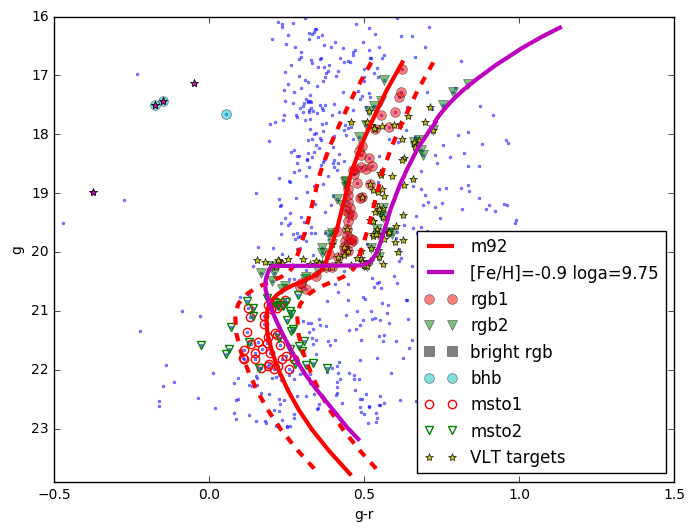

In [109]:
plt.figure(figsize=[8,6])
rgb_cut = 20.7
msto_cut = 22.
bri_cut = des_g0_fiduc_m92.min()-dm_m92_harris+dm
#CMD
plt.plot(s['MAG_PSF_SFD_G'][closetocen]-s['MAG_PSF_SFD_R'][closetocen],s['MAG_PSF_SFD_G'][closetocen],'.',ms=4, alpha=0.5)
plt.plot(gc_gmr_interp, gc_g_interp, color='r', lw=3, zorder=5, label='m92')
plt.plot(gc_gmr_interp+0.1, gc_g_interp, color='r', ls='--', lw=3, zorder=5)
plt.plot(gc_gmr_interp-0.1, gc_g_interp, color='r', ls='--', lw=3, zorder=5)
plt.plot(iso_gmr_interp, iso_g_interp, color='m', lw=3, zorder=5, label='[Fe/H]=-0.9 loga=9.75')
#plt.plot(iso_gmr_interp+0.1, iso_g_interp, color='m', ls='--', lw=3, zorder=5)
#plt.plot(iso_gmr_interp-0.1, iso_g_interp, color='m', ls='--', lw=3, zorder=5)

#FIND STARS NEAR THE EXPECTED RGB
select_rgb = np.zeros_like(s['MAG_PSF_SFD_G']).astype(bool)
for j in np.arange(len(s['MAG_PSF_SFD_G'])):
    if closetocen[j]==1:
#        mindist = min(np.sqrt((s['MAG_PSF_SFD_G'][j] - s['MAG_PSF_SFD_R'][j] - iso_gmr_interp)**2 + \
#                           (s['MAG_PSF_SFD_G'][j] - iso_g_interp)**2))
        mindist = min(np.sqrt((s['MAG_PSF_SFD_G'][j] - s['MAG_PSF_SFD_R'][j] - gc_gmr_interp)**2 + \
                           (s['MAG_PSF_SFD_G'][j] - gc_g_interp)**2))
        minindx = np.argmin(np.sqrt((s['MAG_PSF_SFD_G'][j] - s['MAG_PSF_SFD_R'][j] - gc_gmr_interp)**2 + \
                           (s['MAG_PSF_SFD_G'][j] - gc_g_interp)**2))
        if (mindist < 0.07) & (s['MAG_PSF_SFD_G'][j] < rgb_cut) & (s['MAG_PSF_SFD_G'][j] - s['MAG_PSF_SFD_R'][j] > gc_gmr_interp[minindx]):
            select_rgb[j] = True     
plt.plot(s['MAG_PSF_SFD_G'][select_rgb]-s['MAG_PSF_SFD_R'][select_rgb],s['MAG_PSF_SFD_G'][select_rgb],'ro', ms=7, alpha=0.5, label='rgb1')


 
#PLOT MCMC-SELECTED RGB CANDIDATES
#mcmcrgb = (s['MAG_PSF_SFD_G'] < rgb_cut) & (s['MAG_PSF_SFD_G']-s['MAG_PSF_SFD_R'] > 0.40) & (s['prob'] > 0.25)
#plt.plot(s['MAG_PSF_SFD_G'][mcmcrgb]-s['MAG_PSF_SFD_R'][mcmcrgb],s['MAG_PSF_SFD_G'][mcmcrgb],'y*', label='rgb MCMC')

#FIND STARS LESS NEAR THE EXPECTED RGB
select_rgb2 = np.zeros_like(s['MAG_PSF_SFD_G']).astype(bool)
for j in np.arange(len(s['MAG_PSF_SFD_G'])):
    if (closetocen[j]==1) & (select_rgb[j] == False):
        mindist1 = min(np.sqrt((s['MAG_PSF_SFD_G'][j] - s['MAG_PSF_SFD_R'][j] - iso_gmr_interp)**2 + \
                           (s['MAG_PSF_SFD_G'][j] - iso_g_interp)**2))
        mindist2 = min(np.sqrt((s['MAG_PSF_SFD_G'][j] - s['MAG_PSF_SFD_R'][j] - gc_gmr_interp)**2 + \
                           (s['MAG_PSF_SFD_G'][j] - gc_g_interp)**2))
        if ((mindist1 < 0.03) | (mindist2 < 0.03)) & (s['MAG_PSF_SFD_G'][j] < rgb_cut):
            select_rgb2[j] = True     
plt.plot(s['MAG_PSF_SFD_G'][select_rgb2]-s['MAG_PSF_SFD_R'][select_rgb2],s['MAG_PSF_SFD_G'][select_rgb2], 'gv', ms=7, alpha=0.5, label='rgb2')

#FIND BRIGHTEST RGBS (NOT COVERED WITH M92 ISOCHRONE)
select_bri = np.zeros_like(s['MAG_PSF_SFD_G']).astype(bool)
for j in np.arange(len(s['MAG_PSF_SFD_G'])):
    if closetocen[j]==1 & (select_rgb[j] == False) & (select_rgb2[j] == False):
        mindist = min(np.sqrt((s['MAG_PSF_SFD_G'][j] - s['MAG_PSF_SFD_R'][j] - iso_gmr_interp)**2 + \
                           (s['MAG_PSF_SFD_G'][j] - iso_g_interp)**2))
#        mindist = min(np.sqrt((s['MAG_PSF_SFD_G'][j] - s['MAG_PSF_SFD_R'][j] - gc_gmr_interp)**2 + \
#                           (s['MAG_PSF_SFD_G'][j] - gc_g_interp)**2))
        if (mindist < 0.08) & (s['MAG_PSF_SFD_G'][j] < bri_cut):
            select_bri[j] = True     
plt.plot(s['MAG_PSF_SFD_G'][select_bri]-s['MAG_PSF_SFD_R'][select_bri],s['MAG_PSF_SFD_G'][select_bri],'sk', ms=7, alpha=0.5, label='bright rgb')

#FIND BHB CANDIDATES
select_bhb = (closetocen) & (s['MAG_PSF_SFD_G']-s['MAG_PSF_SFD_R'] < 0.1) \
                & (s['MAG_PSF_SFD_G']-s['MAG_PSF_SFD_R'] > -0.5) \
                & (s['MAG_PSF_SFD_G'] < 1.1+dm)\
                & (s['MAG_PSF_SFD_G'] > 0.1+dm)
plt.plot(s['MAG_PSF_SFD_G'][select_bhb]-s['MAG_PSF_SFD_R'][select_bhb],s['MAG_PSF_SFD_G'][select_bhb],'co', ms=7, alpha=0.5, label='bhb')



#FIND MAIN SEQUENCE STARS
mcmc1 = (closetocen) & (s['prob'] > 0.7) & (s['MAG_PSF_SFD_G'] < msto_cut) & (s['MAG_PSF_SFD_G'] > rgb_cut)
mcmc2 = (closetocen) & (s['prob'] > 0.3) & (s['prob'] < 0.7) & (s['MAG_PSF_SFD_G'] < msto_cut) & (s['MAG_PSF_SFD_G'] > rgb_cut)
plt.plot(s['MAG_PSF_SFD_G'][mcmc1]-s['MAG_PSF_SFD_R'][mcmc1],s['MAG_PSF_SFD_G'][mcmc1], 'o', mfc = 'None', mec='r', mew=1, ms=6, label='msto1')
plt.plot(s['MAG_PSF_SFD_G'][mcmc2]-s['MAG_PSF_SFD_R'][mcmc2],s['MAG_PSF_SFD_G'][mcmc2], 'v', mfc= 'None', mec='g', mew=1, ms=6, label='msto2')


#FIND ALIGNMENT STARS
alignment = (s['MAG_PSF_SFD_R'] < 18) & (s['prob'] < 0.01 ) \
& (s['angsep'] < 15/60.) & (s['isosep'] > 0.14)
#plt.plot(s['MAG_PSF_SFD_G'][alignment]-s['MAG_PSF_SFD_R'][alignment],s['MAG_PSF_SFD_G'][alignment],'ys', alpha=0.7)

plt.ylim(23.9,16)
plt.xlim(-0.5,1.5)

print "# of rgb candidate1:", sum(select_rgb),  ",expected rgb member #:", sum(s['prob'][select_rgb])
print "# of rgb candidate2:", sum(select_rgb2), ",expected rgb member #:", sum(s['prob'][select_rgb2])
print "# of msto candidate1:", sum(mcmc1),  ",expected msto member #:", sum(s['prob'][mcmc1])
print "# of msto candidate2:", sum(mcmc2),  ",expected msto member #:", sum(s['prob'][mcmc2])
print "# of bright rgb candidate:", sum(select_bri),  ",expected bright rgb member #:", sum(s['prob'][select_bri])


            
#target = '10286300071060'
#targetmask = s['QUICK_OBJECT_ID'] == int(target)
#plt.plot(s['MAG_PSF_SFD_G'][targetmask]-s['MAG_PSF_SFD_R'][targetmask],s['MAG_PSF_SFD_G'][targetmask],'c*',mew=2, alpha=1, ms=15)

for i in np.arange(20.5,22.1,0.25):
    print i, sum(s['prob'][(select_rgb | mcmc1) & (s['MAG_PSF_SFD_R']<i)])

    
    
plt.plot(gt['g']-gt['r'], gt['g'], 'y*', alpha=0.9, label='VLT targets')
for i in range(len(gt['ID'])):
    if gt['ID'][i][3:6] == 'BHB':
        plt.plot(gt['g'][i]-gt['r'][i], gt['g'][i], 'm*', alpha=0.9)
        

plt.xlabel('g-r')
plt.ylabel('g')
plt.legend(loc=4)


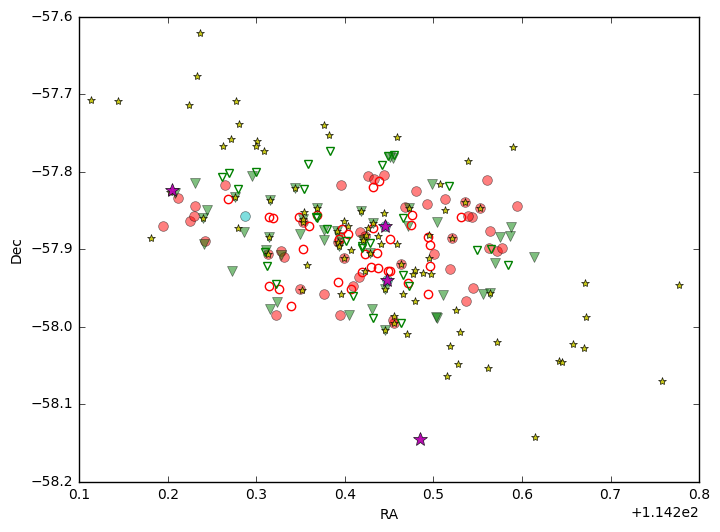

In [103]:
plt.figure(figsize=[8,6])
#PLOT SPATIAL DISTRIBUTION OF STARS
plt.plot(s['ra'][select_rgb],s['dec'][select_rgb],'ro', ms=7, alpha=0.5, label='rgb1')
plt.plot(s['ra'][select_rgb2],s['dec'][select_rgb2],'gv', ms=7, alpha=0.5, label='rgb2')
plt.plot(s['ra'][select_bri],s['dec'][select_bri],'sk', ms=7, alpha=0.5, label='bright rgb')
plt.plot(s['ra'][select_bhb],s['dec'][select_bhb],'co', ms=7, alpha=0.5, label='bright rgb')
plt.plot(s['ra'][mcmc1],s['dec'][mcmc1],'o', mfc = 'None', mec='r', mew=1, ms=6, label='msto1')
plt.plot(s['ra'][mcmc2],s['dec'][mcmc2],'v', mfc= 'None', mec='g', mew=1, ms=6, label='msto2')
#plt.plot(racen,deccen, 'y*')


plt.plot(gt['ra'],gt['dec'], 'y*', alpha=0.9)

for i in range(len(gt['ID'])):
    if gt['ID'][i][3:6] == 'BHB':
        plt.plot(gt['ra'][i], gt['dec'][i], 'm*', ms=10, alpha=0.9)


plt.xlabel('RA')
plt.ylabel('Dec')
#target = '10286300071060'
#targetmask = s['QUICK_OBJECT_ID'] == int(target)
#plt.plot(s['ra'][targetmask],s['dec'][targetmask],'c*',mew=2, alpha=1, ms=10)

In [2]:
pyfits.open(rootdir+'member_prob/small_blob_mcmc_v5.7.fits')[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   72 / length of dimension 1                          
NAXIS2  =                11329 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   13 / number of table fields                         
TTYPE1  = 'QUICK_OBJECT_ID'                                                     
TFORM1  = 'K       '                                                            
TTYPE2  = 'GLON    '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'GLAT    '        